# Sensitivity Estimates for H6C

This notebook performs some simple sensitivity predictions for H6C, run at the start of the season just to get a rough idea of what we might be able to do.

Note that we use the new version of 21cmSense, and in particular the [hera_sensitivity](https://github.com/steven-murray/21cmSense/tree/hera-sensitivity) branch (which should be merged soon...).

In [44]:
import py21cmsense as p21c
from astropy import units as un
from astropy.cosmology.units import littleh
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.coordinates import EarthLocation
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import h5py
%matplotlib inline

## Setup H6C Observatory

First, we create (ideal) antenna positions for the full HERA (no outriggers, but :

In [45]:
hera_ants = p21c.antpos.hera(hex_num=11, separation=14.7*un.m, split_core=True)

In [46]:
len(hera_ants)

320

In H6C we don't have all of the antennas hooked up yet. Dave DeBoer published a list of antennas that are hooked up for H6C here: http://hera.pbworks.com/f/HERA%20Observing%20Season%202022.pdf. So we reduce the antennas to these:

In [4]:
# From Dave's list on the HERA wiki
keep_ants = [3, 4, 5, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
130, 131, 132, 133, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150,
151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
170, 171, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190,
191, 192, 193, 194, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 219, 220,
221, 222, 223, 224, 225, 226, 227, 228, 229, 237, 238, 239, 240, 241, 242, 243, 244, 245,
246, 261, 262]

In [47]:
len(keep_ants)

209

In this notebook we won't assume we'll necessarily keep all the antennas at once. In fact, at the start of the season we were only able to correlate up to 192, so we set that as our maximum. We keep four subsets of antennas to have a look at how the noise will compare:

In [5]:
np.random.seed(1420)

keep_ants_192 = np.random.choice(keep_ants, 192, replace=False)
keep_ants_150 = np.random.choice(keep_ants, 150, replace=False)
keep_ants_100 = np.random.choice(keep_ants, 100, replace=False)
keep_ants_75 = np.random.choice(keep_ants, 75, replace=False)


In [6]:
h6c = hera_ants[keep_ants_192]
hfull = hera_ants
h6c150 = hera_ants[keep_ants_150]
h6c100 = hera_ants[keep_ants_100]
h6c75 = hera_ants[keep_ants_75]

Then we can look at the positions of the antennas in the array (orange are for all possible antennas in H6C):

(-150.0, 150.0)

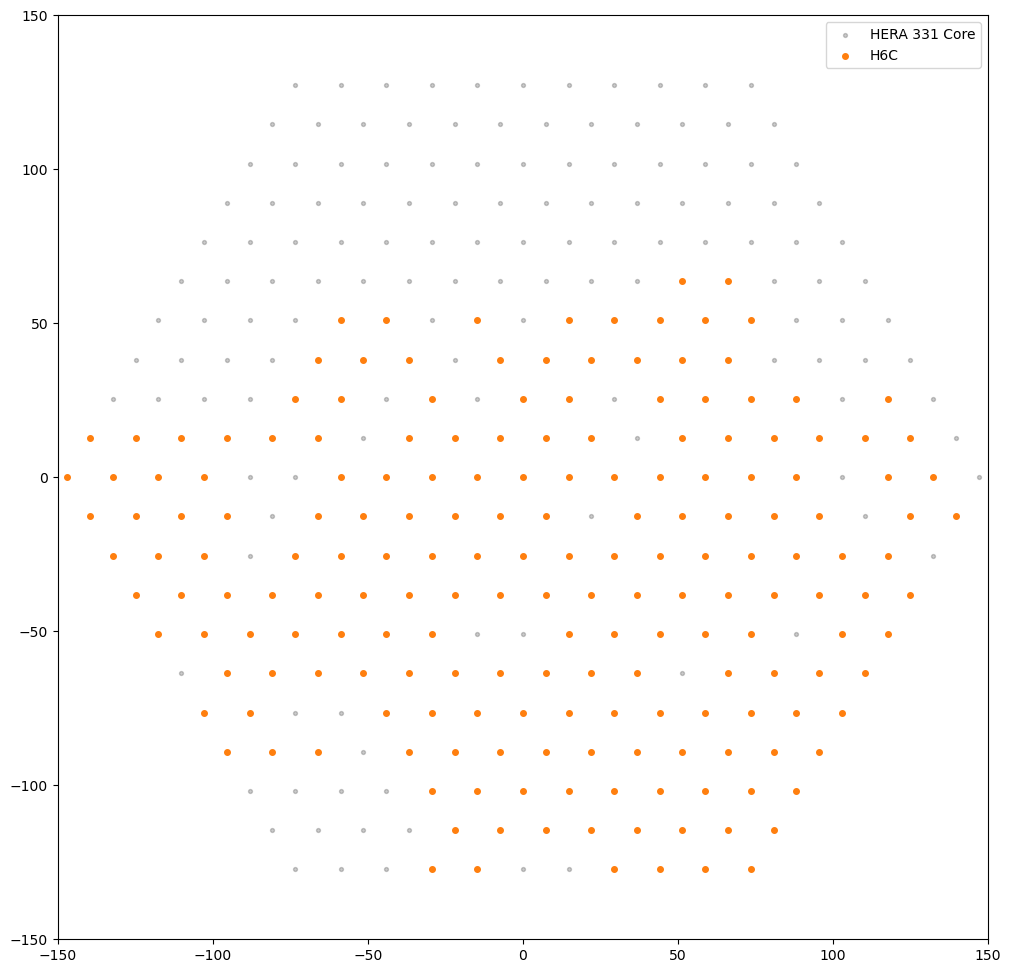

In [7]:
plt.figure(figsize=(12, 12))
plt.scatter(hfull[:, 0], hfull[:, 1], color='k', alpha=0.2, s=8, label='HERA 331 Core')
plt.scatter(h6c[:, 0], h6c[:, 1], color='C1', alpha=1, s=16, label='H6C')

plt.legend()
plt.xlim(-150, 150)
plt.ylim(-150, 150)

We set up the beam as a simple Gaussian with a width inversely proportional to the dish size and frequency. Here we set a simple representative frequency, but we will update that later in the notebook to produce each observed band:

In [8]:
beam = p21c.GaussianBeam(frequency=150*un.MHz, dish_size=14*un.m)

The receiver temperature is a function of frequency, so we create it as such here, with values taken from Fagnoni+19 and interpolated to our frequencies:

In [9]:
rcv_temp_freq = np.array([50,100,150,200,250])
rcv_temp = np.array([555,88,77,58,60])

In [10]:
rcvtemp = spline(rcv_temp_freq, rcv_temp)

def rcv_temp_fnc(freq):
    return rcvtemp(freq.to_value("MHz")) * un.K

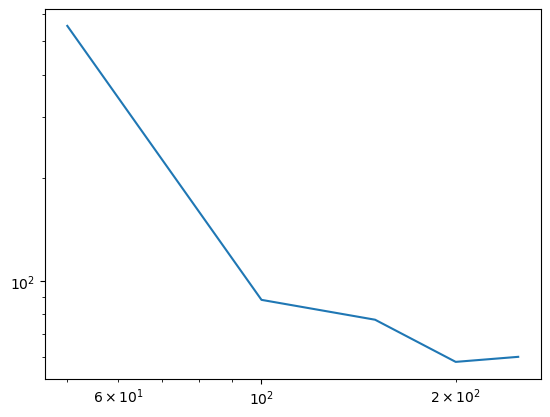

In [11]:
plt.plot(rcv_temp_freq, rcv_temp)
plt.xscale('log')
plt.yscale('log')

In [12]:
hera_h6c = p21c.Observatory(antpos=h6c, beam=beam, latitude=-30.721*un.deg,Trcv=rcv_temp_fnc) 
hera_full = p21c.Observatory(antpos=hfull, beam=beam, latitude=-30.721*un.deg,Trcv=rcv_temp_fnc) 
hera_150 = p21c.Observatory(antpos=h6c150, beam=beam, latitude=-30.721*un.deg,Trcv=rcv_temp_fnc) 
hera_100 = p21c.Observatory(antpos=h6c100, beam=beam, latitude=-30.721*un.deg,Trcv=rcv_temp_fnc) 
hera_75 = p21c.Observatory(antpos=h6c75, beam=beam, latitude=-30.721*un.deg,Trcv=rcv_temp_fnc) 


## Setup Observation Characteristics

#### Frequency/Bands

Now set up the observing band/frequency characteristics. The channel size was taken directly from H4C data (same setup as H6C). We use a 10 MHz spectral window for all windows, which is roughly similar to the spw's used in H4C.

In [13]:
hera_channel_size = 122070.3125 * un.Hz

In [50]:
n_channels = int(10*un.MHz / hera_channel_size)
print("Nchannels: ", n_channels)

Nchannels:  81


#### LST-bin size

Inherently, 21cmSense assumes the telescope sees roughly the same set of LSTs every night for some number of nights. The actual observing pattern of HERA is more complicated than this, and we try to map the actual observing pattern back to what 21cmSense requires.

First, we set the actual LST bin size (i.e. integration time that is coherently averaged). This is set from H1C IDR3 (Josh's paper):

In [16]:
lst_bin_size = 300*un.s

Now, we calculate the number of times each LST-bin is observed over the H6C season (taken to be 2022-09 to 2023-04), given the location of HERA:

In [52]:
lst_bins = np.arange(0, 24, lst_bin_size.to_value("hour"))

In [53]:
heraloc = EarthLocation(lat=-32*un.deg, lon=21.5*un.deg)

In [54]:
start_time = Time('2022-09-24 17:00:00', scale='utc')
end_time = Time('2022-09-25 04:00:00', scale='utc')

end_date   = Time('2023-04-01 17:00:00', scale='utc')

lst_counts = np.zeros_like(lst_bins)

while start_time <= end_date:
    start_lst = start_time.sidereal_time('mean', longitude=heraloc).hour
    end_lst = end_time.sidereal_time("mean", longitude=heraloc).hour
    
    if start_lst > end_lst:
        lst_counts[lst_bins < end_lst] += 1
        lst_counts[lst_bins > start_lst] += 1
    else:
        lst_counts[(start_lst < lst_bins) & (lst_bins < end_lst)] += 1
        
    start_time += 24*un.hour
    end_time += 24*un.hour
        

Text(0, 0.5, 'Number of times observed')

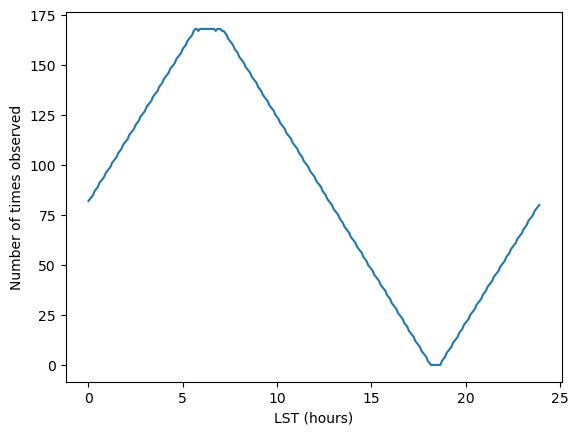

In [55]:
plt.plot(lst_bins, lst_counts)
plt.xlabel("LST (hours)")
plt.ylabel("Number of times observed")

This is a reasonable first-order idea of the amount of time each LST bin is observed. However, there are some LSTs that we will almost certainly throw out, given previous seasons (i.e. H1C IDR3):

In [56]:
# Now, cancel out LSTs that might be crap
lst_counts[lst_bins < 0.75] = 0                     # Fornax A?
lst_counts[(2.75 < lst_bins) & (lst_bins < 4)] = 0  # bunch of crosstalk
lst_counts[lst_bins > 14.75] = 0                    # bad crosstalk


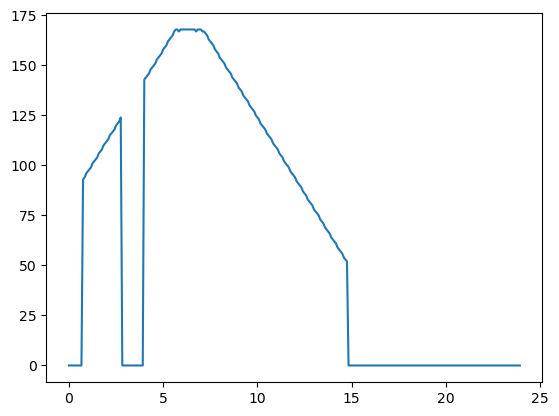

In [57]:
plt.plot(lst_bins, lst_counts)

Now we have the number of times each LST is observed, but 21cmSense only takes a time per day, and a number of days. 
We can convert between the two by using the formulas:

\begin{equation}
n'_{\rm days} = \sqrt{\frac{\sum_{\rm lst} n_{\rm days,lst}^2}{n_{\rm lst}}}
\end{equation}

and 

\begin{equation}
t'_{\rm day} = t_{\rm lstbin} n_{\rm lst}.
\end{equation}

Furthermore, we apply a "viewing efficiency" -- i.e. a rate at which any given observed LST bin is kept (after accounting for flagging or other observational loss). We use 75% efficiency here.

In [23]:
viewing_efficiency = 0.75
mask = lst_counts > 0
ndays_eff = np.sqrt( np.sum(lst_counts[mask]**2) / np.sum(mask)) * viewing_efficiency

In [24]:
ndays_eff

95.01577755231479

In [25]:
eff_time_per_day = (lst_bin_size * np.sum(mask)).to(un.hour)

In [26]:
eff_time_per_day

<Quantity 12.91666667 h>

#### The Observation

Finally, we construct our Observation. Along with the above settings, we also filter out baselines where the EW component is smaller than 15m, and all baselines longer than 150m, similar to H4C. Furthermore, we do not coherently average non-instantanteously-redundant baselines. Finally, we set a sky model that roughly matches H4C validation simulations of the GSM at LST=7:

In [27]:
obs_h6c = p21c.Observation(
    observatory=hera_h6c, 
    time_per_day=eff_time_per_day, 
    n_channels=n_channels, 
    lst_bin_size=lst_bin_size,
    bandwidth=n_channels*hera_channel_size.to("MHz"), 
    n_days=ndays_eff, 
    baseline_filters=(
        p21c.baseline_filters.BaselineRange(bl_min=15*un.m, direction='ew'),
        p21c.baseline_filters.BaselineRange(bl_max=150*un.m, direction='mag'),
    ),
    redundancy_tol=1,   # number of decimal places, i.e. 0.1m
    coherent=False, 
    spectral_index=2.5,       # These values gotten from H4C Validation simulations of GSM at LST=7.
    tsky_amplitude=150*un.K,   
    tsky_ref_freq=150*un.MHz
)

In [28]:
obs_full = obs_h6c.clone(observatory=hera_full)
obs_150 = obs_h6c.clone(observatory=hera_150)
obs_100 = obs_h6c.clone(observatory=hera_100)
obs_75 = obs_h6c.clone(observatory=hera_75)


## The Sensitivity

Now construct the sensitivity itself. We apply a conservative horizon buffer of 300ns, similar to H1C. It is possible we could do better than this. We also use the fiducial theory model of Munoz+2021:

In [29]:
sense_h6c = p21c.PowerSpectrum(
    observation=obs_h6c, 
    horizon_buffer=(300*un.ns * p21c.conversions.dk_deta(9.5)).to(littleh/un.Mpc),  # from IDR3
    foreground_model='moderate', 
    theory_model=p21c.theory.EOS2021()
)

In [30]:
sense_full = sense_h6c.clone(observation=obs_full)
sense_150 = sense_h6c.clone(observation=obs_150)
sense_100 = sense_h6c.clone(observation=obs_100)
sense_75 = sense_h6c.clone(observation=obs_75)


We observe from 55-205 MHz in 10 MHz bands, excluding FM (90-110 MHz) and orbcomm (125-140 MHz):

In [31]:
bands = [x for x in np.arange(55., 205., 10.0) if not (90 < x < 110) and not (125 < x < 140)]

In [32]:
senses_h6c = []
senses_full= []

In [33]:
p21c.config.PROGRESS = False

In [34]:
obs_h6c.bl_min

<Quantity 25.46114687 m>

In [59]:
def plot_all(sense_h6c, sense_full, sense_150, sense_100, sense_75, taper_factor=2.0):
    fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 12), constrained_layout=True)

    axf = ax.flatten()

    snrs_full = []
    snrs_h6c = []
    snrs_150 = []
    snrs_100 = []
    snrs_75 = []

    # One-Sigma points from H1C IDR3 FIELD C.
    h1c_limits_hik = np.array([0.27, 0.34, 0.41, 0.48, 0.55, 0.62, 0.69])
    h1c_limits_hi = np.array([129, 206, 360, 595, 921, 1305, 1778])
    
    h1c_limits_lowk = np.array([0.23, 0.29, 0.36, 0.42, 0.48, 0.54, 0.60])
    h1c_limits_low = np.array([472, 687, 1185, 1993, 3067, 4320, 5898])
    
    for i, band in enumerate(bands):
        plt.sca(axf[i])
        sense_h6c = sense_h6c.at_frequency(band*un.MHz)
        sense_full = sense_full.at_frequency(band*un.MHz)
        sense_75 = sense_75.at_frequency(band*un.MHz)
        sense_100 = sense_100.at_frequency(band*un.MHz)
        sense_150 = sense_150.at_frequency(band*un.MHz)

        snr_full = sense_full.calculate_significance() / taper_factor
        snr_h6c = sense_h6c.calculate_significance() / taper_factor
        snr_150 = sense_150.calculate_significance() / taper_factor
        snr_100 = sense_100.calculate_significance() / taper_factor
        snr_75 = sense_75.calculate_significance() / taper_factor

        snrs_full.append(snr_full)
        snrs_h6c.append(snr_h6c)
        snrs_150.append(snr_150)
        snrs_100.append(snr_100)
        snrs_75.append(snr_75)

        plt.text(0.12, 1e6, f"SNR: {snr_full:.1f} | {snr_h6c:.1f} | {snr_150:.1f} | {snr_100:.1f} | {snr_75:.1f}")

        if np.abs(band - 1420/8.9) <= 5.0:
            plt.scatter(h1c_limits_hik, h1c_limits_hi, marker='v', color='C1')
        elif np.abs(band - 1420/11.4) <= 5.0:
            plt.scatter(h1c_limits_lowk, h1c_limits_low, marker='v', color='C1')
            
        plt.plot(sense_h6c.k1d, sense_h6c.delta_squared, color='k', label='Fiducial Model (EOS21)')
        plt.plot(sense_h6c.k1d, sense_h6c.calculate_sensitivity_1d(sample=True, thermal=False)*taper_factor, label='Sample Var.', color='C0')
        plt.plot(sense_h6c.k1d, sense_h6c.calculate_sensitivity_1d(sample=True, thermal=True)*taper_factor, label='192 Ants', color='C2')

        plt.plot(sense_full.k1d, sense_full.calculate_sensitivity_1d(sample=True, thermal=False)*taper_factor,  ls='--', color='C0')
        plt.plot(sense_full.k1d, sense_full.calculate_sensitivity_1d(sample=True, thermal=True)*taper_factor, ls='--', color='C2', label='Full Array',)

        plt.plot(sense_full.k1d, sense_150.calculate_sensitivity_1d(sample=True, thermal=False)*taper_factor, ls=':', color='C0')
        plt.plot(sense_full.k1d, sense_150.calculate_sensitivity_1d(sample=True, thermal=True)*taper_factor, ls=':', color='C2', label='150 Ants')

        plt.plot(sense_full.k1d, sense_100.calculate_sensitivity_1d(sample=True, thermal=False)*taper_factor, ls='-.', color='C0')
        plt.plot(sense_full.k1d, sense_100.calculate_sensitivity_1d(sample=True, thermal=True)*taper_factor, ls='-.', color='C2', label='100 Ants')

        plt.plot(sense_full.k1d, sense_75.calculate_sensitivity_1d(sample=True, thermal=False)*taper_factor, ls=':', lw=1, color='C0')
        plt.plot(sense_full.k1d, sense_75.calculate_sensitivity_1d(sample=True, thermal=True)*taper_factor, ls=':', lw=1, color='C2', label='75 Ants')

        plt.yscale('log')
        plt.xscale('log')
        plt.xlim((0.1, 2.))
        if i>7:
            plt.xlabel(f"k [h/Mpc]")
        if not i%4:
            plt.ylabel(r"$\Delta^2$")
        plt.title(f"{band} MHz | {sense_h6c.observation.n_days} days")

    axf[0].legend()
    rms = lambda x: np.sqrt(np.sum(np.square(x)))

    fig.suptitle(f"Total SNR: {rms(snr_full):.1f} | {rms(snr_h6c):.1f} | {rms(snr_150):.1f} | {rms(snr_100):.1f} | {rms(snrs_75):.1f}")

In [63]:
np.sum(np.blackman(81)**2) / np.sum(np.blackman(81))**2 * 81

1.7483418367346948

The following plots the expected noise-power (green) against the fiducial theoretical model, in all bands, for our different observing assumptions. In orange are the H1C IDR3 Field-C 1-$\sigma$ uncertainties for comparison (NOT the 2-$\sigma$ upper limits, because that's not comparable to our predictions).To our predictions, we apply a factor of 2 boost to the noise power due to applying a Blackman-Harris window (computed as $N_{\rm chan} \cdot \sum w_i^2 / (\sum w_i)^2$

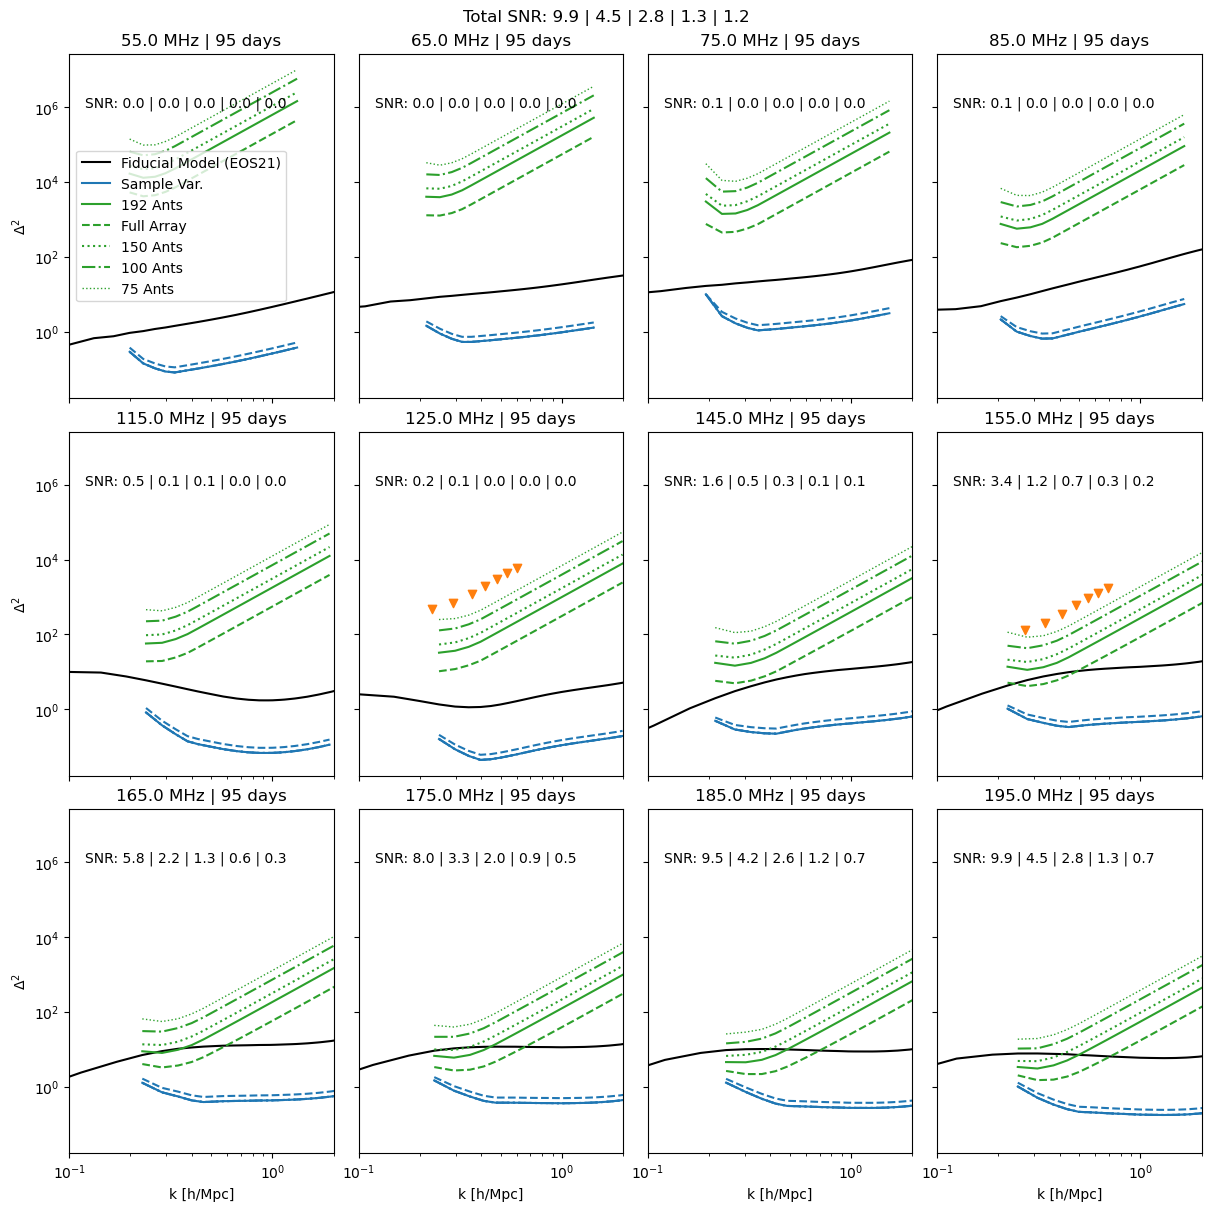

In [60]:
plot_all(sense_h6c, sense_full, sense_150, sense_100, sense_75, taper_factor=2.0)

## Single Field

Above we plotted the fully averaged sensitivity for all fields (which is hopefully what we'll actually use). But the uncertainties for H1C were presented per-field. For comparison it could be useful to produce a single field for H6C.

So, we re-do everything above except we zero out everything outside of Field C (which is what we compared to above):

In [65]:
start_time = Time('2022-09-24 17:00:00', scale='utc')
end_time = Time('2022-09-25 04:00:00', scale='utc')

end_date   = Time('2023-04-01 17:00:00', scale='utc')

lst_counts = np.zeros_like(lst_bins)

while start_time <= end_date:
    start_lst = start_time.sidereal_time('mean', longitude=heraloc).hour
    end_lst = end_time.sidereal_time("mean", longitude=heraloc).hour
    
    if start_lst > end_lst:
        lst_counts[lst_bins < end_lst] += 1
        lst_counts[lst_bins > start_lst] += 1
    else:
        lst_counts[(start_lst < lst_bins) & (lst_bins < end_lst)] += 1
        
    start_time += 24*un.hour
    end_time += 24*un.hour
        

In [68]:
# Just Keep Field C
lst_counts[lst_bins < 4] = 0        
lst_counts[lst_bins > 6.25] = 0        


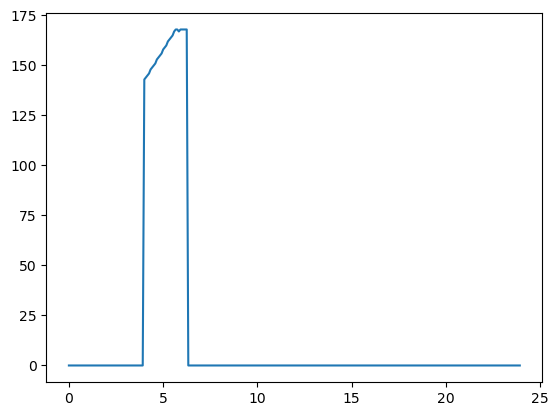

In [67]:
plt.plot(lst_bins, lst_counts)

In [69]:
viewing_efficiency = 0.75
mask = lst_counts > 0
ndays_eff = np.sqrt( np.sum(lst_counts[mask]**2) / np.sum(mask)) * viewing_efficiency

In [70]:
ndays_eff

118.96959958325488

In [71]:
eff_time_per_day = (lst_bin_size * np.sum(mask)).to(un.hour)

In [72]:
eff_time_per_day

<Quantity 2.33333333 h>

In [74]:
obs_h6c = p21c.Observation(
    observatory=hera_h6c, 
    time_per_day=eff_time_per_day, 
    n_channels=n_channels, 
    lst_bin_size=lst_bin_size,
    bandwidth=n_channels*hera_channel_size.to("MHz"), 
    n_days=ndays_eff, 
    baseline_filters=(
        p21c.baseline_filters.BaselineRange(bl_min=15*un.m, direction='ew'),
        p21c.baseline_filters.BaselineRange(bl_max=150*un.m, direction='mag'),
    ),
    redundancy_tol=1,   # number of decimal places, i.e. 0.1m
    coherent=False, 
    spectral_index=2.5, 
    tsky_amplitude=150*un.K, 
    tsky_ref_freq=150*un.MHz
)

In [75]:
obs_full = obs_h6c.clone(observatory=hera_full)
obs_150 = obs_h6c.clone(observatory=hera_150)
obs_100 = obs_h6c.clone(observatory=hera_100)
obs_75 = obs_h6c.clone(observatory=hera_75)


In [76]:
sense_h6c = p21c.PowerSpectrum(
    observation=obs_h6c, 
    horizon_buffer=(300*un.ns * p21c.conversions.dk_deta(9.5)).to(littleh/un.Mpc),  # from IDR3
    foreground_model='moderate', 
    theory_model=p21c.theory.EOS2021()
)

In [77]:
sense_full = sense_h6c.clone(observation=obs_full)
sense_150 = sense_h6c.clone(observation=obs_150)
sense_100 = sense_h6c.clone(observation=obs_100)
sense_75 = sense_h6c.clone(observation=obs_75)


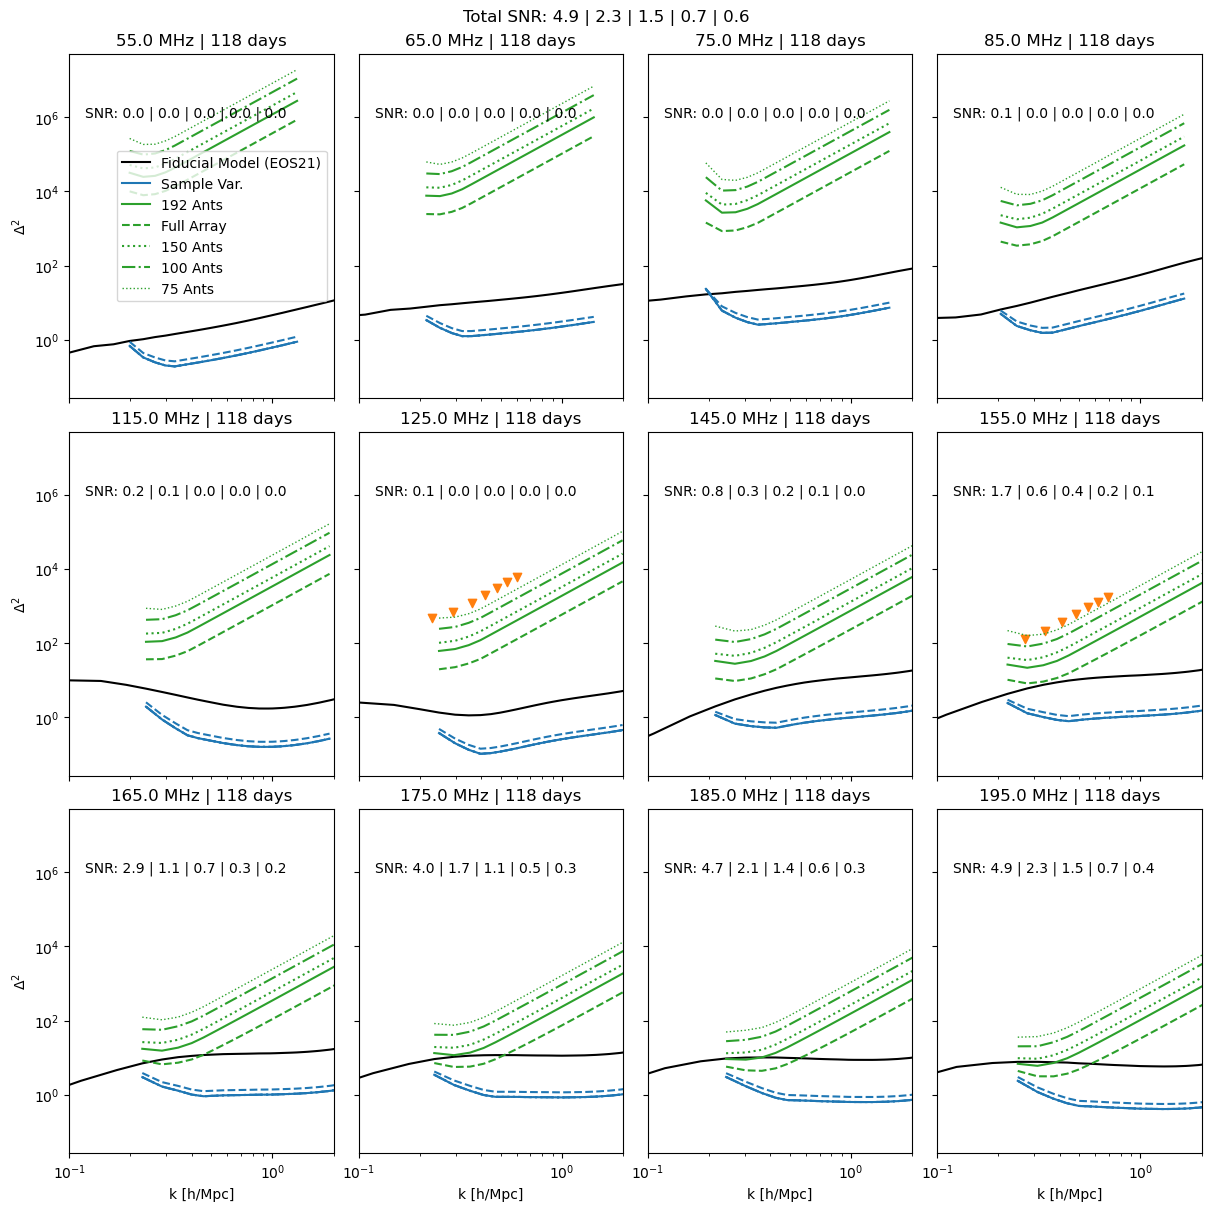

In [78]:
plot_all(sense_h6c, sense_full, sense_150, sense_100, sense_75)

We noteice here that our predictions are essentially consistent with H1C IDR3 for our 75-antenna case. Thus, if we can maintain better than 75 antennas on average over the season, we will be doing better. 

# Output Mock Observations...

In [42]:
def save_mock(sense, taper_factor=2.0):
    nants = len(sense.observation.observatory.antpos)
    
    with h5py.File(f"H6C-{nants}-ants.h5", 'w') as fl:
        fl.attrs['viewing_efficiency'] = viewing_efficiency
        
        for i, band in enumerate(bands):
            sense = sense.at_frequency(band*un.MHz)
            grp = fl.create_group(f"{int(band)} MHz")
            grp['k_hMpc'] = sense.k1d
            grp['delta_squared'] = sense.delta_squared
            grp['one_sigma_thermal'] = sense.calculate_sensitivity_1d(sample=False, thermal=True) * taper_factor
            grp['one_sigma_sample_and thermal'] = sense.calculate_sensitivity_1d(sample=True, thermal=True) * taper_factor
            

In [43]:
save_mock(sense_100)